<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Métodos estadísticos</h4>
<h4 style="text-align: center;">Tarea: Unidad 3</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andrés Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia – UNAD</h4>
<h4 style="text-align: center;">Fecha: noviembre de 2024</h4>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

In [78]:
import urllib
from sqlalchemy import create_engine
import pandas as pd

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=a1s2d3f4;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a través de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [79]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

            price  habitaciones  \
0    120000000.00          2.00   
1    105000000.00          1.00   
2   7850000000.00          1.00   
3  22000000000.00          1.00   
4 107158800000.00           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogotá - Germania   
2  Edificio en venta, Bogotá - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...    1.00  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...    2.00  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   es

In [80]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,4601.00,3526.00,3859.00,4515.00,4523.00,3543.00,2605.00,1925.00,1881.00,1294.00
mean,45229304719.44,3.03,2.88,3.94,178.66,175.37,3.38,4210811.89,4.96,4.91
std,1420799640262.00,7.21,2.68,1.42,218.99,220.36,5.38,62631168.63,3.71,3.60
min,1000.00,1.00,1.00,1.00,0.01,1.00,1.00,3.00,1.00,1.00
25%,186100000.00,2.00,1.00,3.00,45.00,43.00,1.00,166000.00,2.00,2.00
50%,479000000.00,3.00,2.00,4.00,79.00,75.00,2.00,360000.00,4.00,4.00
75%,2390000000.00,3.00,3.00,5.00,214.50,200.00,3.00,799400.00,6.00,6.00
max,95000000000000.00,400.00,60.00,7.00,998.00,998.00,127.00,2000000000.00,21.00,21.00


In [81]:
trash_columns = ['descr', 'link','id']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price           4601 non-null   float64       
 1   habitaciones    3526 non-null   float64       
 2   banyos          3859 non-null   float64       
 3   tipoInmueble    4588 non-null   object        
 4   estadoInmueble  4588 non-null   object        
 5   areaConstruida  4523 non-null   float64       
 6   areaPrivada     3543 non-null   float64       
 7   antiguedad      4601 non-null   object        
 8   parqueaderos    2605 non-null   float64       
 9   administracion  1925 non-null   float64       
 10  pisoNumero      1881 non-null   float64       
 11  totalPisos      1294 non-null   float64       
 12  comodidades     3775 non-null   object        
 13  ubicacion       4601 non-null   object        
 14  estrato         4515 non-null   float64       
 15  date

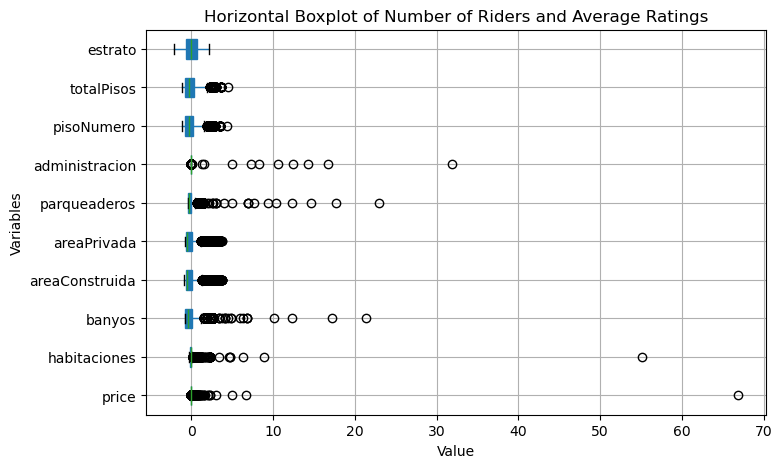

In [82]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Numérica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categórica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Numérica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Horizontal Boxplot of Number of Riders and Average Ratings')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df_nuevo)

In [83]:
mapa_antiguedad = {
    "menor a 1 año": 1,
    "1 a 8 años": 2,
    "9 a 15 años": 3,
    "16 a 30 años": 4,
    "más de 30 años": 5,
    "¡Pregúntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

,price,habitaciones,banyos,tipoInmueble,estadoInmueble,areaConstruida,areaPrivada,antiguedad,parqueaderos,administracion,pisoNumero,totalPisos,comodidades,ubicacion,estrato,date_created,date_modified
1248,9000000000.00,4.00,7.00,Apartamento,¡Pregúntale!,630.00,NaN,3,5.00,5300000.00,9.00,9.00,None,"Los rosales, Bogotá, Bogotá, d.c.",6.00,NaT,2025-03-23 09:51:28.470
4179,177400000.00,2.00,1.00,Apartamento,¡Pregúntale!,44.00,NaN,3,NaN,135000.00,5.00,5.00,•Closet•Cocina Integral•Instalación de gas•Sal...,"Villa gladys, Bogotá, Bogotá, d.c.",2.00,NaT,2025-03-23 09:51:28.470
2129,1299000000.00,3.00,4.00,Apartamento,¡Pregúntale!,228.00,NaN,4,2.00,1772000.00,2.00,2.00,•Cerca centro comercial•Closet•Cocina Integral...,"Los rosales, Bogotá, Bogotá, d.c.",6.00,NaT,2025-03-23 09:51:28.470
4155,407210000.00,3.00,3.00,Apartamento,¡Pregúntale!,86.00,86.00,5,2.00,813800.00,3.00,NaN,•Circuito cerrado de TV•Citófono•Cocina Integr...,"El contador, Bogotá, Bogotá, d.c.",5.00,NaT,2025-03-23 09:53:10.803
4492,450000000.00,NaN,NaN,Cabaña,Excelenteestado,63.22,63.22,4,NaN,NaN,NaN,NaN,•Acceso Pavimentado•Alarma Contra Incendio•Asc...,"Centro Internacional, Bogotá, Bogotá, d.c.",6.00,2025-03-20 22:38:18,2025-03-23 09:53:41.587


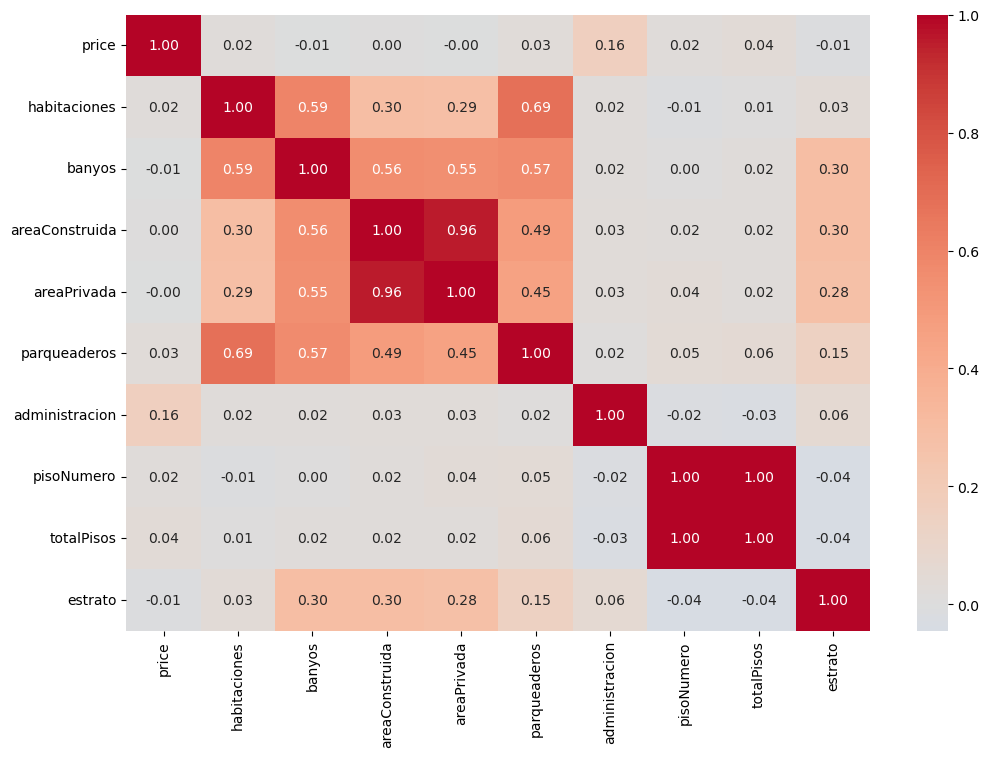

In [84]:
numerics = [num for num in df_nuevo.columns if clasificar_variable(df_nuevo[num].dtype)=='Numérica']

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_[numerics].corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df_nuevo)

Column: price, log skew factor: 5.548, mean: 45229304719.4, median: 479000000.0
Column: habitaciones, log skew factor: 1.009, mean: 3.0, median: 3.0
Column: banyos, log skew factor: 1.365, mean: 2.9, median: 2.0
Column: id, log skew factor: 0.813, mean: 159342709.7, median: 192109896.0
Column: areaConstruida, log skew factor: 1.816, mean: 178.7, median: 79.0
Column: areaPrivada, log skew factor: 1.849, mean: 175.4, median: 75.0
Column: parqueaderos, log skew factor: 1.525, mean: 3.4, median: 2.0
Column: administracion, log skew factor: 3.459, mean: 4210811.9, median: 360000.0
Column: pisoNumero, log skew factor: 1.216, mean: 5.0, median: 4.0
Column: totalPisos, log skew factor: 1.206, mean: 4.9, median: 4.0
Column: estrato, log skew factor: 0.986, mean: 3.9, median: 4.0


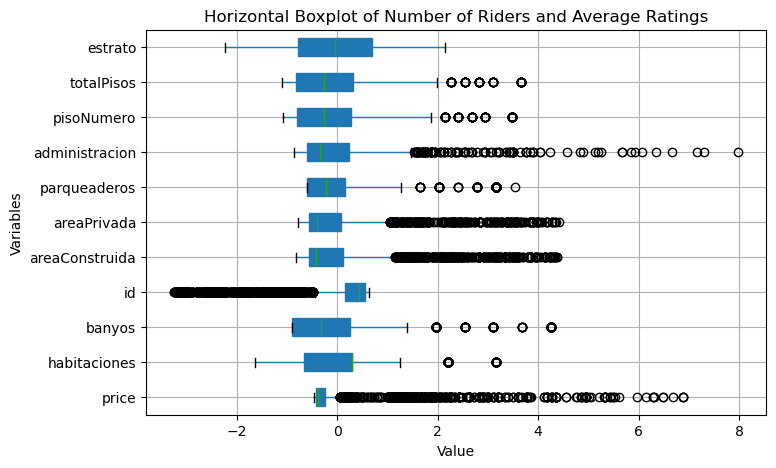

In [85]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series, factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor:
    
    lower_bound = Q1 - factor * IQR * (1 / log_skew_factor)
    upper_bound = Q3 + factor * IQR * log_skew_factor
    
    The log_skew_factor = log((mean * e) / median).
    """
    valid = series.dropna()
    if valid.empty:
        return -np.inf, np.inf  # no valid data
    
    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)
    IQR = Q3 - Q1
    
    mean_val = valid.mean()
    median_val = valid.median()

    # If median is zero or negative, or mean is NaN, fallback to standard IQR
    if median_val <= 0 or np.isnan(mean_val):
        return (Q1 - factor * IQR, Q3 + factor * IQR)
    
    # Compute the log-skew factor:
    # This equals 1 when mean == median (after factoring in e)
    log_skew_factor =  np.log(mean_val * np.e / median_val) # (mean_val / median_val) #
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}")

    # Adjust bounds
    lower_bound = Q1 - factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else (Q1 - factor * IQR)
    upper_bound = Q3 + factor * IQR * log_skew_factor

    return lower_bound, upper_bound

def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df, factor=3.0)
create_box(df_no_outliers)

In [87]:
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,3536.00,2734.00,3126.00,3494.00,3520.00,2628.00,2169.00,1772.00,1727.00,1213.00
mean,2405957756.38,2.70,2.56,4.06,157.33,152.50,2.60,628563.35,5.01,4.90
std,5178658830.27,1.04,1.75,1.37,192.34,191.96,2.66,736462.47,3.73,3.57
min,1000.00,1.00,1.00,1.00,0.01,1.00,1.00,3.00,1.00,1.00
25%,220000000.00,2.00,1.00,3.00,48.00,45.00,1.00,187075.00,2.00,2.00
50%,450000000.00,3.00,2.00,4.00,78.00,74.40,2.00,380000.00,4.00,4.00
75%,1200000000.00,3.00,3.00,5.00,180.00,167.00,3.00,800000.00,6.00,6.00
max,38000000000.00,6.00,10.00,7.00,998.00,998.00,12.00,6500000.00,18.00,18.00


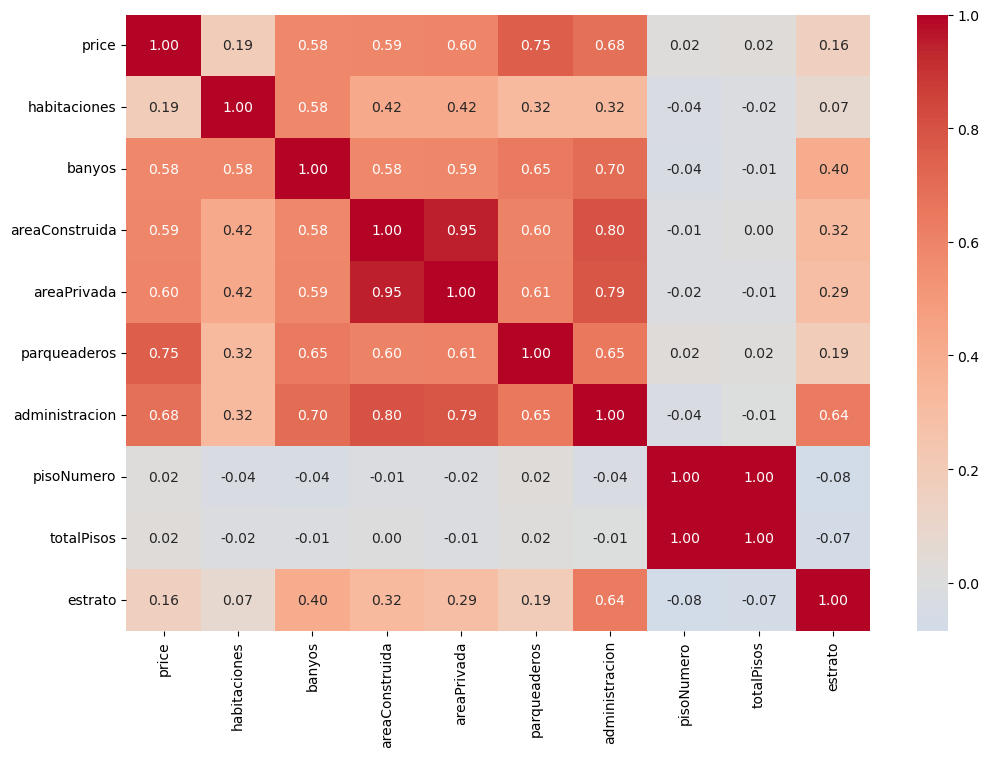

In [88]:
corr_matrix(df_no_outliers)

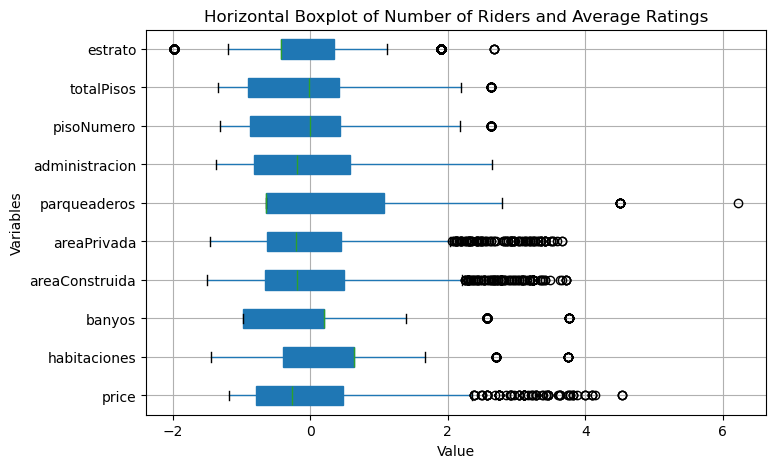

In [89]:
def remove_outliers_mad(series, threshold=3.0):
    """
    Returns a boolean mask where True = not an outlier (or is NaN), 
    and False = outlier, based on Median Absolute Deviation (MAD).
    """
    valid = series.dropna()
    median = valid.median()
    mad = (valid - median).abs().median()
    
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    
    # Keep NaNs or values within [lower_bound, upper_bound]
    return series.isna() | ((series >= lower_bound) & (series <= upper_bound))

def remove_outliers_mad_all_cols(df, threshold=3.0):
    """
    Applies MAD-based outlier removal to each numeric column in df.
    Returns a cleaned DataFrame where rows that are outliers in 
    ANY numeric column are removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # Update the mask for each numeric column
    for col in numeric_cols:
        col_mask = remove_outliers_mad(df[col], threshold=threshold)
        # Keep rows that are non-outliers for this column as well
        mask &= col_mask
    
    # Filter the DataFrame using the combined mask
    return df[mask].reset_index(drop=True)


df_mad_no_outliers = remove_outliers_mad_all_cols(df_nuevo, threshold=3.0)
create_box(df_mad_no_outliers)

In [90]:
summary = df_mad_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,2774.00,2342.00,2410.00,2735.00,2757.00,2183.00,1373.00,1416.00,1374.00,929.00
mean,330993142.87,2.39,1.83,3.56,63.54,60.82,1.38,359876.15,4.01,4.05
std,280287320.00,0.96,0.84,1.29,42.04,40.83,0.58,261008.91,2.28,2.26
min,508000.00,1.00,1.00,1.00,0.01,1.00,1.00,10.00,1.00,1.00
25%,110000000.00,2.00,1.00,3.00,36.00,35.00,1.00,143875.00,2.00,2.00
50%,256100000.00,3.00,2.00,3.00,55.00,52.00,1.00,308000.00,4.00,4.00
75%,463825000.00,3.00,2.00,4.00,84.00,79.00,2.00,508250.00,5.00,5.00
max,1600000000.00,6.00,5.00,7.00,220.00,210.00,5.00,1050700.00,10.00,10.00


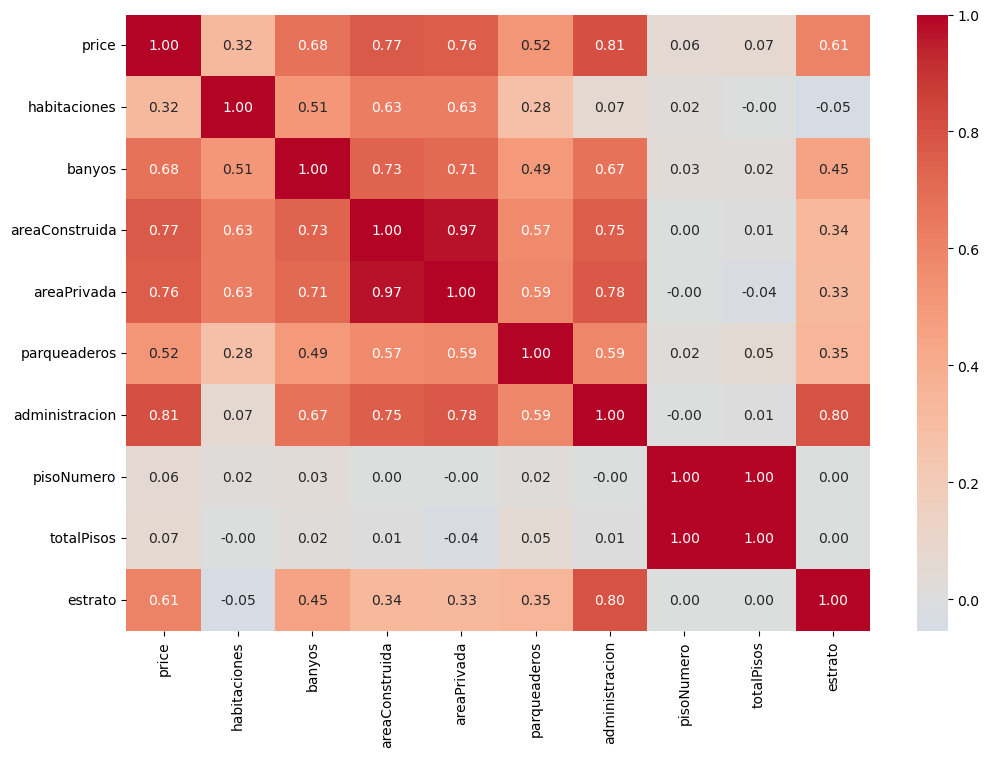

In [91]:
corr_matrix(df_mad_no_outliers)

In [94]:
dummy_columns =["tipoInmueble", "estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_normalized,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

KeyError: "None of [Index(['tipoInmueble', 'estadoInmueble', 'ubicacion'], dtype='object')] are in the [columns]"

In [59]:
# Reemplazar NaN con cadena vacía para evitar problemas
df_encoded['comodidades'] = df_encoded['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_encoded['comodidades'].str.get_dummies(sep='•')

# Unir al DataFrame original
df_final = df_encoded.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

Index(['price', 'habitaciones', 'banyos', 'areaConstruida', 'areaPrivada',
       'antiguedad', 'parqueaderos', 'administracion', 'pisoNumero',
       'totalPisos',
       ...
       'Zona Comercial', 'Zona Industrial', 'Zona Infantil',
       'Zona Residencial', 'Zona de BBQ', 'Zona de lavandería', 'Zonas Verdes',
       'Árboles frutales', 'Área Rural', 'Área Urbana'],
      dtype='object', length=850)

In [60]:
# función para generar escalado usando standard scaler
def generate_standard_scaled(df_):
  scaler=StandardScaler()
  for col in df_.columns:
    df_[col] = scaler.fit_transform(df_[[col]])
  return df_

df_final = df_final.replace('', np.nan)
df_scaled = generate_standard_scaled(df_final)
df_scaled.sample(5)

,price,habitaciones,banyos,areaConstruida,areaPrivada,antiguedad,parqueaderos,administracion,pisoNumero,totalPisos,...,Zona Comercial,Zona Industrial,Zona Infantil,Zona Residencial,Zona de BBQ,Zona de lavandería,Zonas Verdes,Árboles frutales,Área Rural,Área Urbana
2727,-0.04,0.10,0.18,0.02,0.22,-0.39,-0.16,-0.05,-0.54,-0.51,...,-0.45,-0.16,-0.23,-0.38,-0.15,-0.28,-0.19,-0.03,-0.08,-0.22
1086,-0.03,-0.31,3.56,-0.60,-0.44,1.32,-0.16,NaN,-0.54,-0.51,...,2.21,-0.16,-0.23,-0.38,-0.15,-0.28,-0.19,-0.03,-0.08,-0.22
692,-0.04,-0.31,-0.83,-0.77,-0.63,0.47,NaN,NaN,-0.54,-0.51,...,2.21,-0.16,-0.23,-0.38,-0.15,-0.28,-0.19,-0.03,-0.08,-0.22
568,-0.03,-0.17,-0.83,-0.80,-0.66,0.47,1.12,NaN,-0.54,-0.51,...,2.21,-0.16,-0.23,-0.38,-0.15,-0.28,-0.19,-0.03,-0.08,-0.22
1200,-0.04,-0.31,-0.49,-0.69,-0.54,NaN,NaN,NaN,-0.54,-0.51,...,-0.45,-0.16,-0.23,-0.38,-0.15,-0.28,-0.19,-0.03,-0.08,-0.22


NameError: name 'clasificar_variable' is not defined

# PASO 2

## 1) Análisis de componentes principales CPA.

### Calcular las componentes principales

In [6]:



# Crear el modelo de PCA
pca = PCA(n_components=df_scaled.shape[1])


# Ajustar el modelo y transformar los datos
principal_components = pca.fit_transform(df_scaled)


# Cargar las cargas principales
cargas_principales = pca.components_

# Crear un DataFrame para mayor claridad
cargas_df = pd.DataFrame(
    cargas_principales,
    columns=df_scaled.columns,  # Usar los nombres de las variables originales
    index=[f"Componente {i+1}" for i in range(pca.n_components_)]
)
# Multiplicar cada celda por 100 y agregar el símbolo '%'
cargas_df_percent = cargas_df.applymap(lambda x: f"{round(x * 100, 2)}%")
print("matriz de componentes vs variables")
# Mostrar el DataFrame
cargas_df_percent


<ipython-input-6-048f8d1ac6f2>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cargas_df_percent = cargas_df.applymap(lambda x: f"{round(x * 100, 2)}%")


,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
Componente 1,-0.74%,-2.27%,-1.4%,1.6%,-38.71%,-45.18%,-8.25%,1.83%,6.37%,-1.11%,-10.21%,10.94%,0.19%,-6.65%,0.11%,5.99%,54.92%,-54.92%
Componente 2,-15.28%,-16.46%,0.3%,-2.18%,55.44%,49.33%,11.5%,1.03%,-12.4%,11.98%,-8.08%,-3.7%,6.37%,-11.34%,8.04%,-3.19%,40.19%,-40.19%
Componente 3,52.71%,53.89%,10.11%,2.81%,13.64%,14.41%,-33.3%,25.06%,8.35%,-17.61%,32.86%,-14.86%,5.55%,-5.67%,-1.64%,1.57%,12.81%,-12.81%
Componente 4,0.23%,-1.48%,12.03%,1.45%,14.74%,14.94%,-35.46%,-19.61%,54.37%,-6.27%,-33.74%,38.69%,-16.31%,-10.7%,-13.88%,39.18%,-3.84%,3.84%
Componente 5,-7.91%,-8.83%,1.6%,11.51%,1.87%,3.16%,-9.08%,42.47%,-32.72%,-51.3%,-9.57%,58.63%,13.55%,-9.26%,9.52%,-13.52%,-5.02%,5.02%
Componente 6,11.0%,7.67%,9.53%,-13.63%,-2.02%,-2.03%,-17.5%,46.98%,-28.83%,45.74%,-41.37%,-3.96%,-41.48%,9.18%,18.51%,13.53%,-4.54%,4.54%
Componente 7,35.38%,32.68%,1.6%,2.81%,2.72%,3.02%,55.72%,-26.51%,-29.12%,-6.03%,-21.88%,26.98%,-9.54%,17.89%,-29.49%,20.75%,4.62%,-4.62%
Componente 8,2.16%,3.85%,-19.97%,4.71%,-2.7%,-1.48%,-11.96%,19.38%,-7.2%,31.56%,-25.76%,-5.43%,64.53%,-21.58%,-50.47%,6.71%,-5.86%,5.86%
Componente 9,-17.31%,-19.1%,12.6%,-15.49%,-2.5%,-2.85%,6.72%,17.16%,-23.51%,-17.46%,35.43%,-17.49%,-15.78%,-27.57%,-26.47%,66.72%,-0.99%,0.99%
Componente 10,-15.08%,-13.81%,16.99%,-15.98%,6.04%,3.37%,-18.33%,15.45%,2.97%,-8.09%,8.71%,-0.65%,-5.32%,72.66%,-51.43%,-13.82%,7.78%,-7.78%


### Hacer la matriz de Proporción de varianza explicada y acumulada, analice las características más relevantes de las variables,

In [7]:
df_variance_data = pd.DataFrame({
    "nombre columna": [f"Componente {i+1}" for i in range(pca.n_components_)],
    "varianza explicada": [f"{round(i*100,4)}%" for i in pca.explained_variance_ratio_],
    "varianza explicada acumulada": [f"{round(i*100,4)}%" for i in np.cumsum(pca.explained_variance_ratio_)]
})

df_variance_data

,nombre columna,varianza explicada,varianza explicada acumulada
0,Componente 1,11.9108%,11.9108%
1,Componente 2,10.2706%,22.1814%
2,Componente 3,9.9072%,32.0886%
3,Componente 4,8.6963%,40.7849%
4,Componente 5,8.6938%,49.4787%
5,Componente 6,8.0554%,57.5342%
6,Componente 7,7.7405%,65.2747%
7,Componente 8,7.2657%,72.5404%
8,Componente 9,7.2084%,79.7488%
9,Componente 10,7.1758%,86.9247%


In [8]:
for i in range(pca.n_components_):
    componente = f"Componente {i+1}"
    relevantes = cargas_df.loc[componente].sort_values(key=abs, ascending=False).head(4)
    print(f"Variables más relevantes para {componente}:")
    for idx, (var, carga) in enumerate(relevantes.items(), start=1):
        print(f"  {idx}) {var}: {round(carga, 3)}")


Variables más relevantes para Componente 1:
  1) Vehicle_Type_Economy: 0.549
  2) Vehicle_Type_Premium: -0.549
  3) Historical_Cost_of_Ride: -0.452
  4) Expected_Ride_Duration: -0.387
Variables más relevantes para Componente 2:
  1) Expected_Ride_Duration: 0.554
  2) Historical_Cost_of_Ride: 0.493
  3) Vehicle_Type_Premium: -0.402
  4) Vehicle_Type_Economy: 0.402
Variables más relevantes para Componente 3:
  1) Number_of_Drivers: 0.539
  2) Number_of_Riders: 0.527
  3) Location_Category_Rural: -0.333
  4) Customer_Loyalty_Status_Regular: 0.329
Variables más relevantes para Componente 4:
  1) Location_Category_Urban: 0.544
  2) Time_of_Booking_Night: 0.392
  3) Customer_Loyalty_Status_Silver: 0.387
  4) Location_Category_Rural: -0.355
Variables más relevantes para Componente 5:
  1) Customer_Loyalty_Status_Silver: 0.586
  2) Customer_Loyalty_Status_Gold: -0.513
  3) Location_Category_Suburban: 0.425
  4) Location_Category_Urban: -0.327
Variables más relevantes para Componente 6:
  1) Lo

### Interpretar las componentes principales mediante el gráfico de Screeplot, revise si es posible reducir la dimensionalidad.

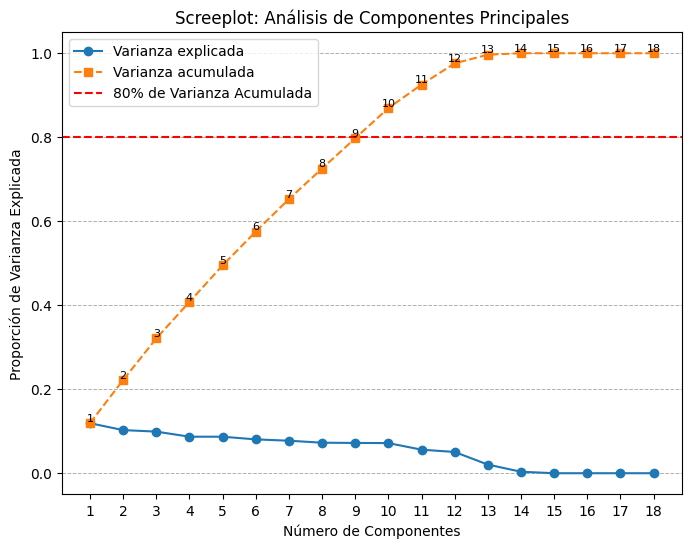

In [30]:
# Calcular la varianza explicada y acumulada
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

plt.figure(figsize=(8, 6))

# Plot varianza explicada and acumulada
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada, marker='o', label='Varianza explicada')
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='s', linestyle='--', label='Varianza acumulada')

# Add labels above each point
for i, (x, y) in enumerate(zip(range(1, len(varianza_acumulada) + 1), varianza_acumulada)):
    plt.text(x, y, f"{x}", fontsize=8, ha='center', va='bottom')

# Additional plot details
plt.title('Screeplot: Análisis de Componentes Principales')
plt.xlabel('Número de Componentes')
plt.ylabel('Proporción de Varianza Explicada')
plt.xticks(range(1, len(varianza_explicada) + 1))
plt.axhline(y=0.8, color='r', linestyle='--', label='80% de Varianza Acumulada')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


Los primeros 10 componentes principales explican más del 80% de la varianza total, lo que indica que es posible reducir la dimensionalidad de las 18 variables originales a solo 10 componentes, preservando la mayor parte de la información relevante en los datos. Sin embargo, si se desea conservar el 100% de la varianza, sería necesario mantener un total de 14 componentes.


### Diseñar el gráfico de loadings para las componentes principales e interprete los resultados.

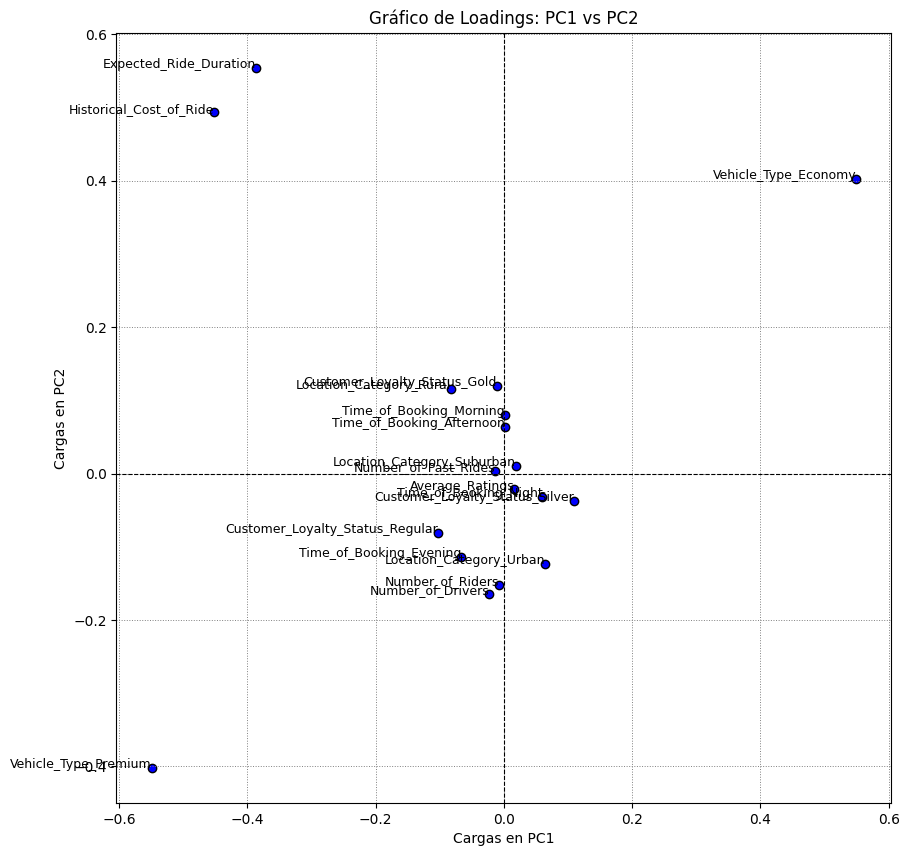

In [74]:
# Seleccionar las cargas principales de las dos primeras componentes
loadings_pc1 = pca.components_[0]  # Cargas para PC1
loadings_pc2 = pca.components_[1]  # Cargas para PC2
variables = df_scaled.columns      # Nombres de las variables originales

# Crear el gráfico de loadings
plt.figure(figsize=(10, 10))
plt.scatter(loadings_pc1, loadings_pc2, c='blue', edgecolor='k')

# Añadir etiquetas a los puntos
for i, variable in enumerate(variables):
    plt.text(loadings_pc1[i], loadings_pc2[i], variable, fontsize=9, ha='right')

# Configurar el gráfico
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Gráfico de Loadings: PC1 vs PC2")
plt.xlabel("Cargas en PC1")
plt.ylabel("Cargas en PC2")
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.show()


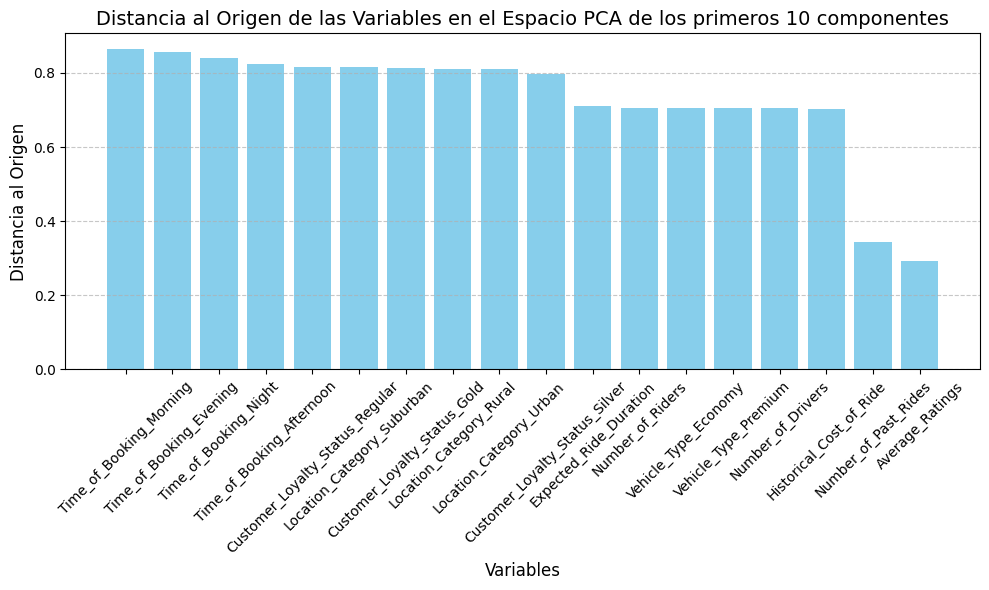

In [73]:
# Seleccionar las cargas principales de los primeros 10 componentes
componentes_usados = 10
cargas_seleccionadas = pca.components_[:componentes_usados, :]

# Calcular la distancia euclidiana al origen considerando solo los primeros 10 componentes
distancia_al_origen_10 = np.sqrt(np.square(cargas_seleccionadas).sum(axis=0))

# Crear un DataFrame para visualizar los resultados
variables_distancia_10 = pd.DataFrame({
    'Variable': df_scaled.columns,
    'Distancia al Origen (Primeros 10 Componentes)': distancia_al_origen_10
}).sort_values(by='Distancia al Origen (Primeros 10 Componentes)', ascending=False)


# Graficar las distancias
plt.figure(figsize=(10, 6))
plt.bar(
    variables_distancia_10['Variable'],
    variables_distancia_10['Distancia al Origen (Primeros 10 Componentes)'],
    color='skyblue'
)
plt.title("Distancia al Origen de las Variables en el Espacio PCA de los primeros 10 componentes", fontsize=14)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Distancia al Origen", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



El cálculo de la distancia euclidiana, basado en el peso de las variables en los primeros 10 componentes principales, revela que las variables más relevantes están relacionadas con la hora de la reserva, seguidas por el nivel de lealtad del cliente y la ubicación.

### Extraer conclusiones del CPA.

- Aplicando el algoritmo PCA, se puede reducir el número de variables a 10, manteniendo una explicación de la varianza superior al 80%. Si se desea conservar el 100% de la varianza, sería necesario utilizar 14 componentes principales.
- El gráfico de loadings para los primeros componentes principales indica que, en los dos primeros componentes, las variables más destacadas por su carga son: Vehicle_Type_Economy, Vehicle_Type_Premium, Expected_Ride_Duration y Historical_Cost_of_Ride.
- Ampliando el análisis de los loadings a los 10 primeros componentes principales (los que explican más del 80% de la varianza), se observa que las variables más influyentes están relacionadas con la hora de la reserva, el nivel de lealtad del cliente y la ubicación.En cambio, las de menor pesos fueron las del average ratings y el número de viajos pasados.

## 2) Agrupamiento K - Medias.

### Implementar el algoritmo de clúster K-means con cuatro segmentos.

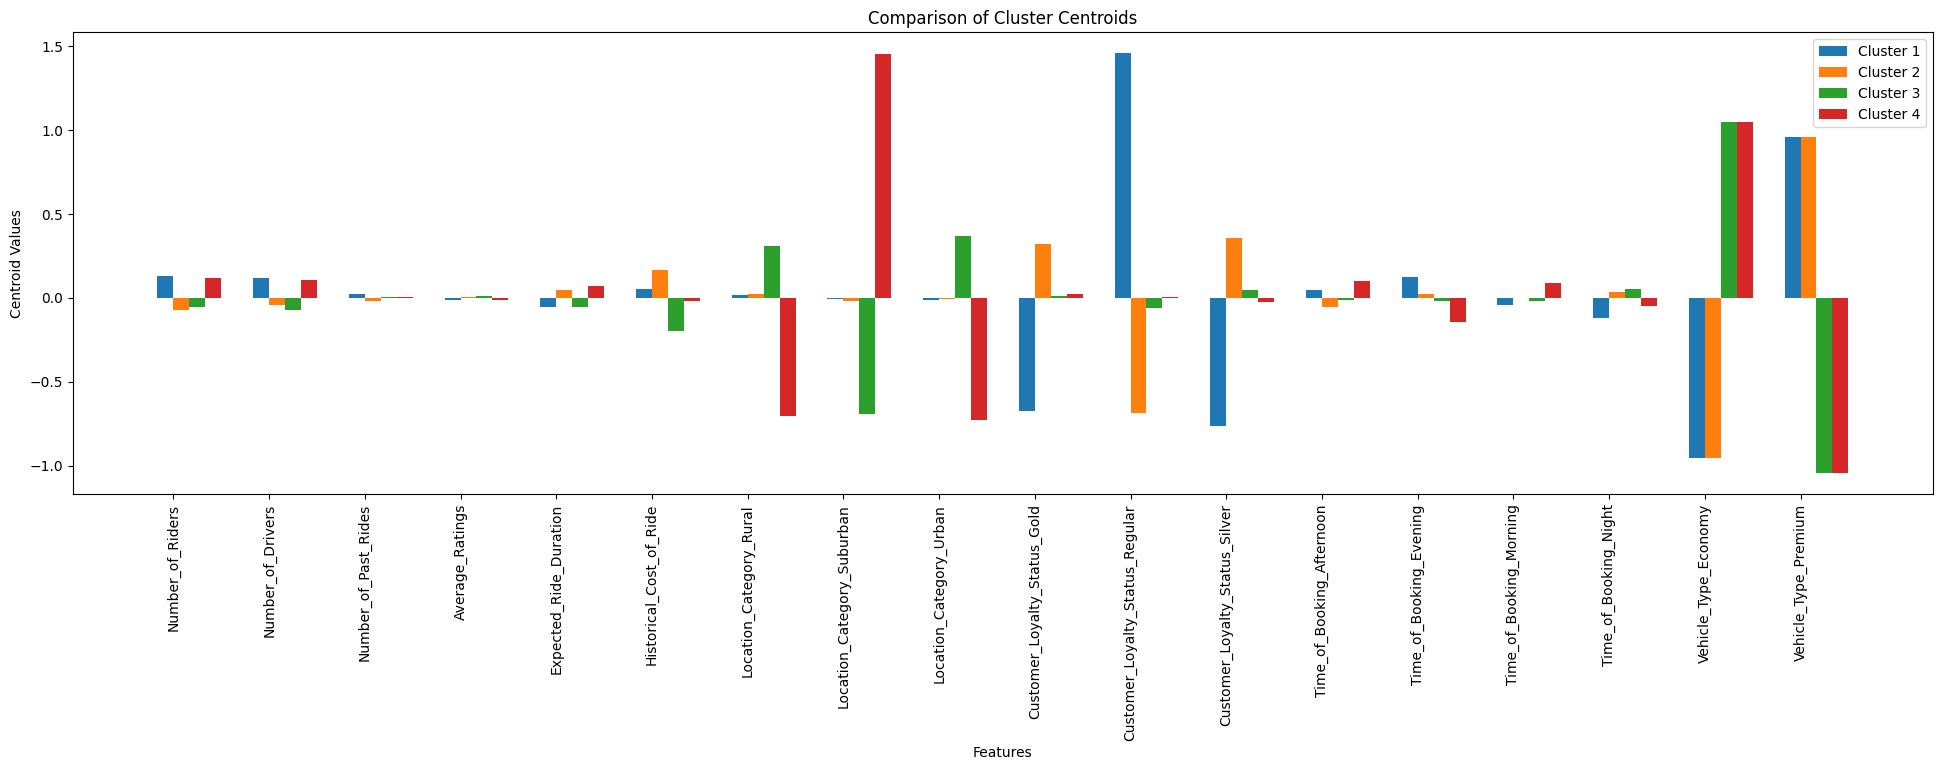

In [10]:
X_scaled_km = df_scaled.copy()

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled_km)
# Print centroids
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(24, 6))
index = np.arange(len(centroids[0]))*3
bar_width = 0.5

rects1 = ax.bar(index, centroids[0], bar_width, label='Cluster 1')
rects2 = ax.bar(index  + bar_width, centroids[1], bar_width, label='Cluster 2')
rects3 = ax.bar(index + (2*bar_width), centroids[2], bar_width, label='Cluster 3')
rects4 = ax.bar(index + (3*bar_width), centroids[3], bar_width, label='Cluster 4')


ax.set_xlabel('Features')
ax.set_ylabel('Centroid Values')
ax.set_title('Comparison of Cluster Centroids')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(X_scaled_km.columns, rotation=90)
ax.legend()

plt.show()

### Calcular el tamaño del clúster mediante una tabla de frecuencias, analice los pesos porcentuales.

In [11]:
# Supongamos que tienes las etiquetas del clúster asignadas
labels = kmeans.labels_

def clusters_frequency(cluster_labels_):
  # Crear una tabla de frecuencias
  cluster_sizes = pd.Series(cluster_labels_).value_counts().sort_index()  # Frecuencias por clúster
  total_data = len(cluster_labels_)  # Total de datos
  percentages = (cluster_sizes / total_data) * 100  # Pesos porcentuales
  # Crear una tabla con frecuencias y porcentajes
  cluster_summary = pd.DataFrame({
    'Cluster': cluster_sizes.index+1,
    'Frecuencia': cluster_sizes.values,
    'Porcentaje (%)': percentages.values
    }) # Mostrar la tabla
  print(cluster_summary)

clusters_frequency(labels)

   Cluster  Frecuencia  Porcentaje (%)
0        1         176            17.6
1        2         346            34.6
2        3         320            32.0
3        4         158            15.8


Los cuatro clústeres tienen un tamaño similar, siendo el clúster 2 el más grande y el clúster 1 el más pequeño. Esto significa que el caso más común lo representan los clientes con alta fidelidad y que prefieren vehículos premium. Por otro lado, el grupo más pequeño está compuesto por clientes que, aunque no tienen alta fidelidad, también prefieren vehículos premium.

### Calcular las medidas de resumen de cada clúster y detectar diferencias entre cada segmento, hacer la interpretación de los resultados.

In [12]:
X_scaled_km['Cluster'] = kmeans.predict(X_scaled_km)

for i in range(0,4):
  print(f"\nSummary descriptive stats for cluster N°{i+1}\n")
  print(X_scaled_km[X_scaled_km["Cluster"]==i].describe())


Summary descriptive stats for cluster N°1

       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  Location_Category_Rural  Location_Category_Suburban  Location_Category_Urban  Customer_Loyalty_Status_Gold  Customer_Loyalty_Status_Regular  Customer_Loyalty_Status_Silver  Time_of_Booking_Afternoon  Time_of_Booking_Evening  Time_of_Booking_Morning  Time_of_Booking_Night  Vehicle_Type_Economy  Vehicle_Type_Premium  Cluster
count        176.000000         176.000000            176.000000       176.000000              176.000000               176.000000               176.000000                  176.000000               176.000000                  1.760000e+02                     1.760000e+02                    1.760000e+02                 176.000000               176.000000               176.000000             176.000000          1.760000e+02          1.760000e+02    176.0
mean           0.132520           0.120925

In [13]:
from sklearn.metrics import silhouette_samples

def silhouette_per_cluster(X, labels):
    # Calcular el silhouette score para cada punto
    silhouette_values = silhouette_samples(X, labels)
    # Promedio del silhouette score por clúster
    cluster_silhouette = [f"cluster {i+1}: {silhouette_values[labels == i].mean()}" for i in np.unique(labels)]
    return "\n".join(cluster_silhouette)

# Cálculo del silhouette score por clúster
silhouette_scores = silhouette_per_cluster(X_scaled_km, kmeans.labels_)
print("Silhouette Score por clúster:\n", silhouette_scores)

Silhouette Score por clúster:
 cluster 1: 0.156666648710496
cluster 2: 0.0912932130773448
cluster 3: 0.09064623031168645
cluster 4: 0.15775469179705423


In [14]:
def average_distance_to_centroid(X, labels, centroids):
    distances = []
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        avg_distance = np.mean(np.linalg.norm(cluster_points - centroids[i], axis=1))
        distances.append(f"Cluster {i+1} {avg_distance}")
    return "\n".join(distances)

# Cálculo de distancia promedio por clúster
avg_distances = average_distance_to_centroid(X_scaled_km.drop(columns=['Cluster']), kmeans.labels_, kmeans.cluster_centers_)
print("Distancia promedio al centroide por clúster:\n", avg_distances)

Distancia promedio al centroide por clúster:
 Cluster 1 3.5885566518053182
Cluster 2 3.8697979871931816
Cluster 3 3.8688534899456952
Cluster 4 3.5799984869903634


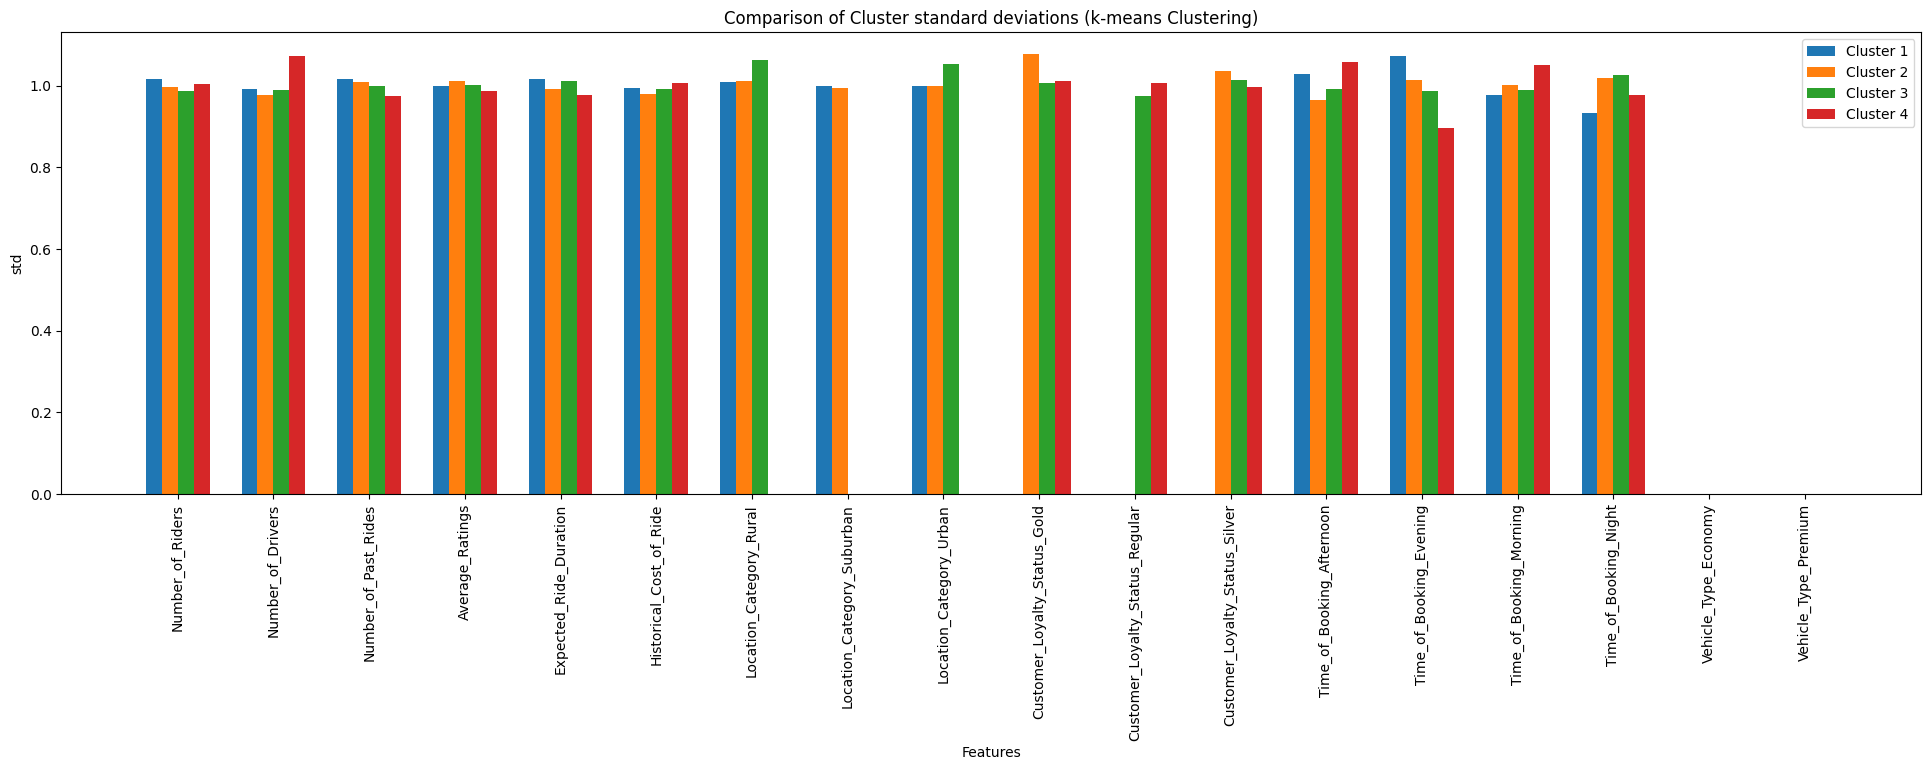

In [15]:
# 4. Calculate the average values for each cluster
cluster_std = X_scaled_km.groupby('Cluster').std()

# 5. Plot the "centroids" (average values for each cluster)
fig, ax = plt.subplots(figsize=(24, 6))
index = np.arange(len(cluster_std.columns)) * 3  # Spacing on x-axis
bar_width = 0.5

# Add bars for each cluster
for i, row in enumerate(cluster_std.values):
    ax.bar(index + (i * bar_width), row, bar_width, label=f'Cluster {i + 1}')

# Configure the plot
ax.set_xlabel('Features')
ax.set_ylabel('std')
ax.set_title('Comparison of Cluster standard deviations (k-means Clustering)')
ax.set_xticks(index + bar_width * (len(cluster_std) - 1) / 2)
ax.set_xticklabels(cluster_std.columns, rotation=90)
ax.legend()

plt.show()

- El Cluster 1 representa a clientes sin membresías especiales pero con preferencia por vehículos de alta gama, sugiriendo un grupo de usuarios que, aunque no están comprometidos con programas de fidelización, valoran la calidad y el lujo en sus experiencias de viaje, posiblemente utilizando el servicio de manera esporádica pero optando siempre por opciones premium.
- El Cluster 2 agrupa a los clientes más valiosos, caracterizados por su alta fidelidad (niveles Oro o Plata) y su preferencia por vehículos premium, indicando un segmento de usuarios frecuentes que aprecian y están dispuestos a pagar por servicios de alta calidad, representando una base de clientes ideal para programas de fidelización y beneficios exclusivos.
- El Cluster 3 abarca usuarios tanto de zonas rurales como urbanas que priorizan las opciones económicas, lo que sugiere un segmento sensible al precio independientemente de su ubicación geográfica, requiriendo estrategias específicas que consideren las particularidades de accesibilidad y disponibilidad en cada área.
- El Cluster 4 está compuesto específicamente por usuarios de áreas suburbanas que eligen vehículos económicos, probablemente representando a familias o individuos que necesitan soluciones de transporte asequibles para sus desplazamientos cotidianos en zonas residenciales, posiblemente para trayectos regulares como el commuting.

### Extraer conclusiones del K-Means.

- Los cuatro clústeres segmentan a los clientes según sus preferencias y comportamientos: el Clúster 1 incluye usuarios ocasionales sin membresías que priorizan vehículos de alta gama por lujo y calidad; el Clúster 2 identifica a los clientes más leales, con membresías Oro o Plata, quienes prefieren opciones premium y son ideales para programas exclusivos; el Clúster 3 agrupa a usuarios rurales y urbanos sensibles al precio, enfocados en opciones económicas; y el Clúster 4 abarca a clientes suburbanos que buscan soluciones asequibles, especialmente para trayectos regulares en áreas residenciales.
- Los cuatro cluster tienen un tamaño similar, siendo el cluster 2 el más grandes, y el cluster 1 el más pequeño, por lo tanto es caso más común lo representan los clientes con alta fidelidad y vehículos premium, mientras que el menor grupo son los clientes sin alta fidelidad pero que también prefieren vehículos premium.
- Cluster 4 se destaca como el mejor definido en este análisis. Presenta el Silhouette Score más alto, lo que indica una mayor cohesión interna y mejor separación respecto a los demás clusters. Además, muestra la menor distancia promedio al centroide, lo que sugiere que es el grupo más compacto y homogéneo. Sus miembros comparten características muy similares entre sí, convirtiéndolo en el cluster más robusto y claramente definido del conjunto.La implicación de esto es que los clientes del Cluster 4 (caracterizados por clientes dezonas suburbanas que prefieren vehículos económicos) forman un segmento altamente coherente y diferenciado. Además, este cluster mantiene una clara separación respecto a otros clusters.
- El análisis también revela que los clústeres con peor rendimiento son el 2 y el 3. Ambos presentan las peores métricas, tanto en cohesión interna como en separación respecto a otros clústeres, lo que los convierte en los grupos menos consistentes del análisis.


## 3) Agrupamiento Jerárquico

### Implementar el método de clúster Hierarchical clustering.

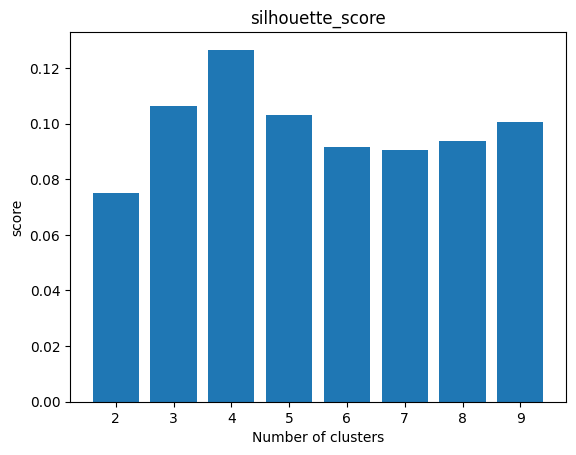

In [16]:
X_scaled_agg = df_scaled.copy()

# setting distance_threshold=0 ensures we compute the full tree.
model1 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model1 = model1.fit(X_scaled_agg)



def clusters_score(df_,score_type,cluster_type):
  score_ = []
  y_=None
  y_c = None
  for k in range(2, 10):
    if cluster_type=="kmeans":
      kmeans = KMeans(n_clusters=k, random_state=42)
      y_c = kmeans.fit_predict(df_)
    elif cluster_type=="agglomerative":
      agg = AgglomerativeClustering(n_clusters=k)
      y_c = agg.fit_predict(df_)

    if score_type=="silhouette_score":
      y_=silhouette_score(df_,y_c)
    elif score_type=="davies_bouldin_score":
      y_=davies_bouldin_score(df_,y_c)
    elif score_type=="calinski_harabasz_score":
      y_=calinski_harabasz_score(df_,y_c)
    score_.append(y_)
  return score_

def graph(score_,score_type):
  plt.bar(range(2, 10), score_)
  plt.xlabel('Number of clusters')
  plt.ylabel('score')
  plt.title(score_type)
  plt.show()
# The Silhouette Score measures how similar an object is to its own cluster compared to other clusters.
# The range of the Silhouette Score is [-1, 1]. A high value indicates that the object is well matched to its own cluster
# and poorly matched to neighboring clusters.
scores = clusters_score(X_scaled_agg, "silhouette_score","agglomerative")
graph(scores,"silhouette_score")

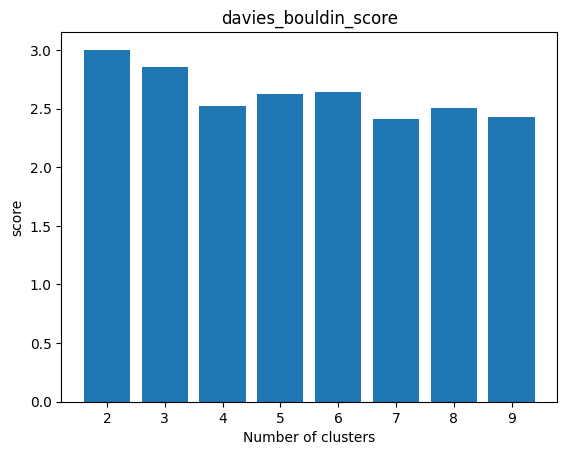

In [17]:
scores = clusters_score(X_scaled_agg, "davies_bouldin_score","agglomerative")
graph(scores,"davies_bouldin_score")

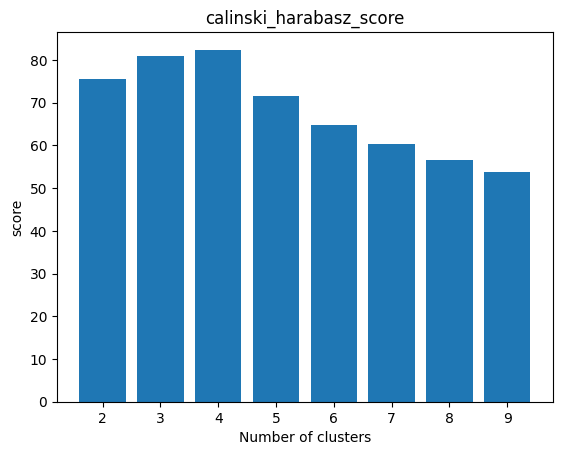

In [18]:

scores = clusters_score(X_scaled_agg, "calinski_harabasz_score","agglomerative")
graph(scores,"calinski_harabasz_score")

### Realizar el dendongrama e interpretar

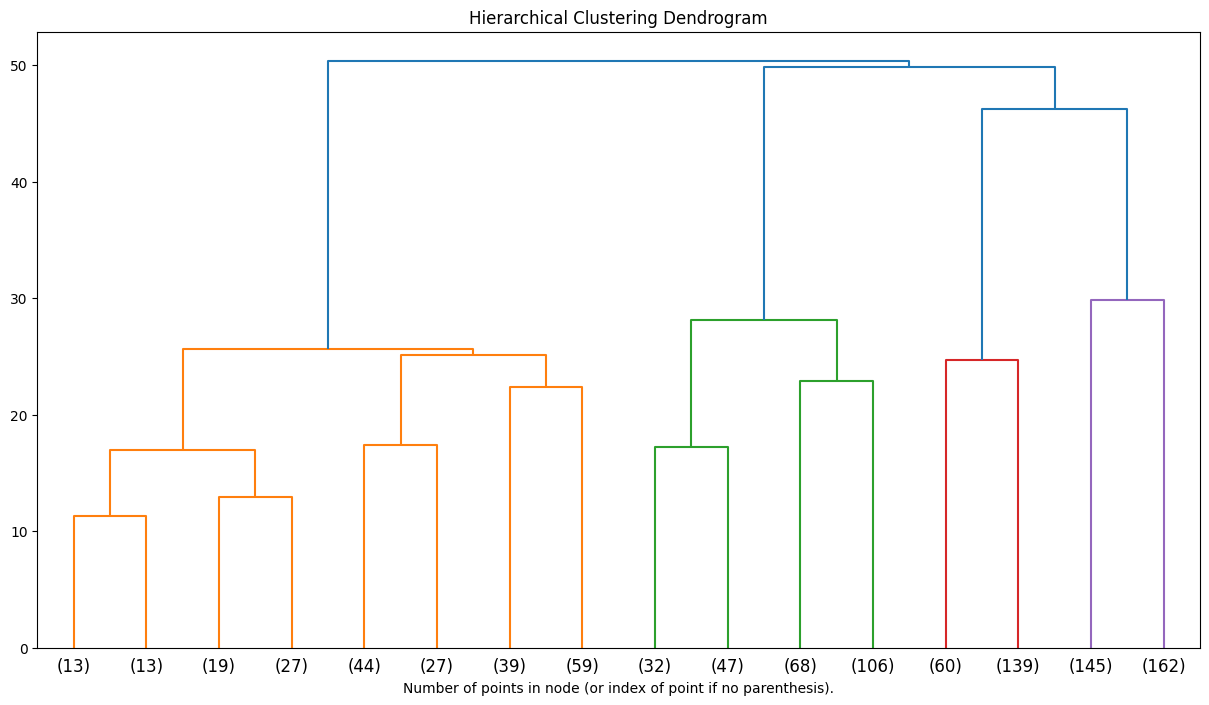

In [75]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(15, 8))  # Ajustar el tamaño del gráfico (ancho x alto)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model1, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

- El dendrograma sugiere que el número óptimo de clústers para el conjunto de datos es 4, ya que este es el máximo número de líneas verticales que se intersectan al trazar una línea horizontal que cruza el mayor salto vertical (la línea vertical más larga), indicando la mayor distancia entre dos fusiones consecutivas en la jerarquía.

### Calcular el tamaño del clúster mediante una tabla de frecuencias, analice los pesos porcentuales

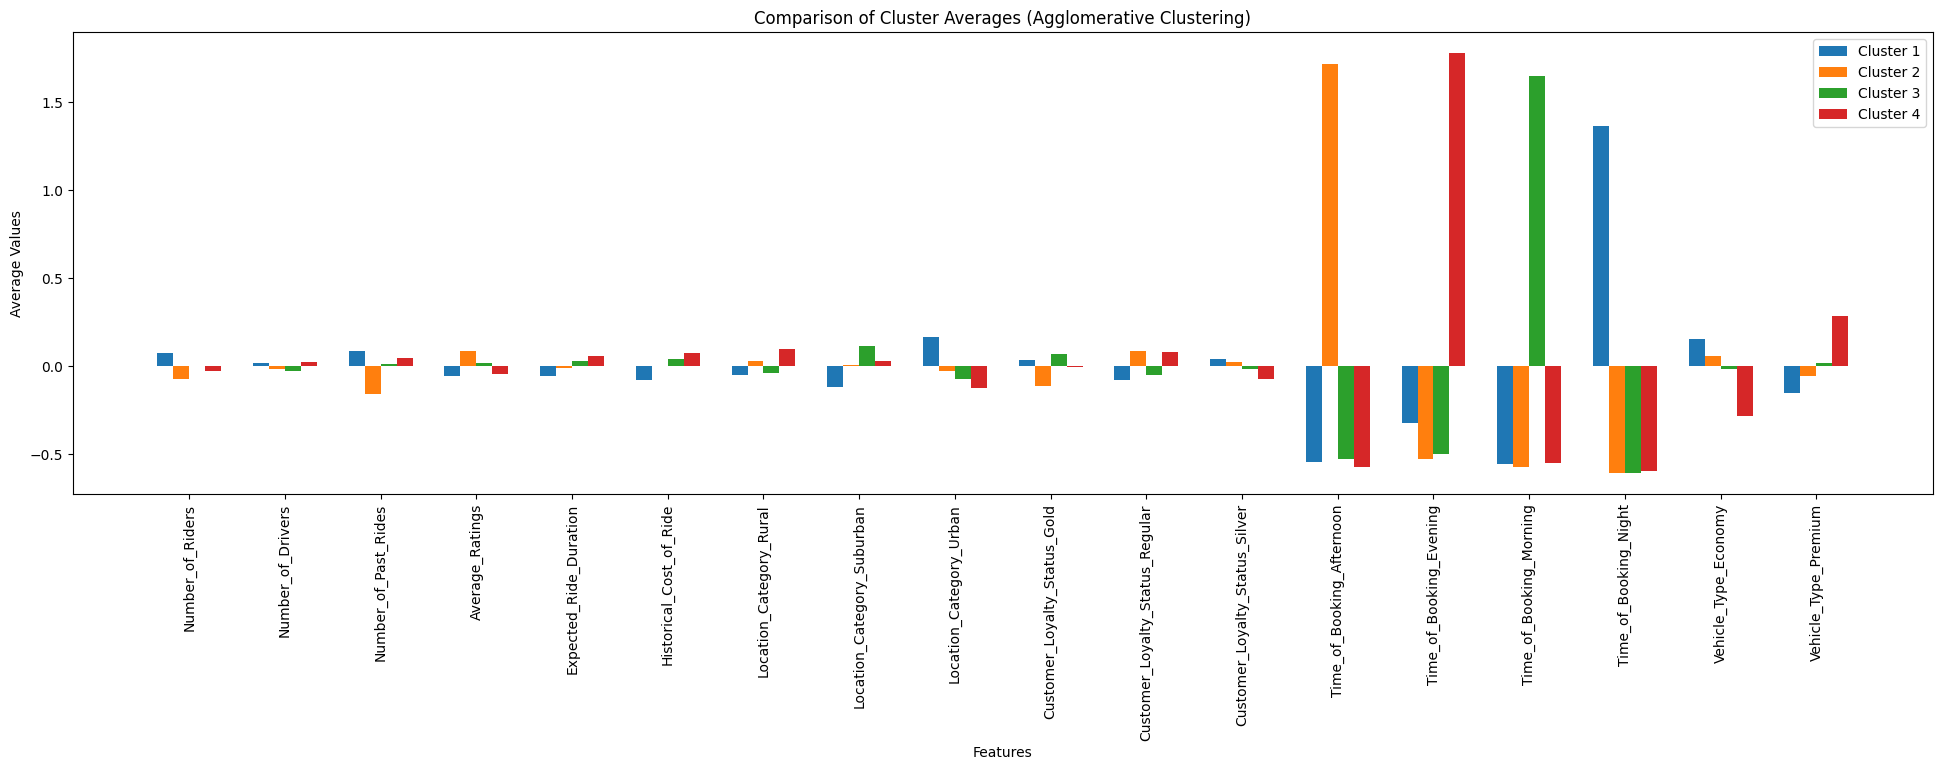

In [20]:
# 2. Fit the Agglomerative Clustering model for 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=4)
cluster_labels = agg_clustering.fit_predict(X_scaled_agg)

# 3. Add cluster labels to the DataFrame
X_scaled_agg['Cluster'] = cluster_labels

# 4. Calculate the average values for each cluster
cluster_means = X_scaled_agg.groupby('Cluster').mean()

# 5. Plot the "centroids" (average values for each cluster)
fig, ax = plt.subplots(figsize=(24, 6))
index = np.arange(len(cluster_means.columns)) * 3  # Spacing on x-axis
bar_width = 0.5

# Add bars for each cluster
for i, row in enumerate(cluster_means.values):
    ax.bar(index + (i * bar_width), row, bar_width, label=f'Cluster {i + 1}')

# Configure the plot
ax.set_xlabel('Features')
ax.set_ylabel('Average Values')
ax.set_title('Comparison of Cluster Averages (Agglomerative Clustering)')
ax.set_xticks(index + bar_width * (len(cluster_means) - 1) / 2)
ax.set_xticklabels(cluster_means.columns, rotation=90)
ax.legend()

plt.show()

In [21]:
clusters_frequency(cluster_labels)

   Cluster  Frecuencia  Porcentaje (%)
0        1         307            30.7
1        2         241            24.1
2        3         253            25.3
3        4         199            19.9


 - clúster más grande es el primero, representando el 30.7% de los registros. Este grupo se caracteriza por clientes que realizan reservas principalmente en la noche (night). Por otro lado, el clúster con menos registros corresponde al cuarto, con el 19.9% de los registros, y este grupo representa a las reservas realizadas durante el anochecer (evening).

### Calcular las medidas de resumen de cada clúster y detectar diferencias entre cada segmento, hacer la interpretación de los resultados.

In [22]:
for i in range(0,4):
  print(f"\nSummary descriptive stats for cluster N°{i+1}\n")
  print(X_scaled_agg[X_scaled_agg["Cluster"]==i].describe())


Summary descriptive stats for cluster N°1

       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  Location_Category_Rural  Location_Category_Suburban  Location_Category_Urban  Customer_Loyalty_Status_Gold  Customer_Loyalty_Status_Regular  Customer_Loyalty_Status_Silver  Time_of_Booking_Afternoon  Time_of_Booking_Evening  Time_of_Booking_Morning  Time_of_Booking_Night  Vehicle_Type_Economy  Vehicle_Type_Premium  Cluster
count        307.000000         307.000000            307.000000       307.000000              307.000000               307.000000               307.000000                  307.000000               307.000000                    307.000000                       307.000000                      307.000000                 307.000000               307.000000               307.000000             307.000000            307.000000            307.000000    307.0
mean           0.075597           0.018743

In [23]:
# Cálculo del silhouette score por clúster
silhouette_scores_agg = silhouette_per_cluster(X_scaled_agg, cluster_labels)
print("Silhouette Score por clúster:\n", silhouette_scores_agg)

Silhouette Score por clúster:
 cluster 1: 0.1328233639045748
cluster 2: 0.15748490574565696
cluster 3: 0.14529453600398734
cluster 4: 0.166464965659019


In [24]:
def cluster_cohesion(X, labels):
    cohesion = []
    for i,cluster in enumerate(np.unique(labels)):
        cluster_points = X[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        distance = np.sum((cluster_points - centroid) ** 2)
        cohesion.append(f"cluster {i+1}: {distance}")
    return "\n".join(cohesion)

# Calcular cohesión por clúster
cohesion_scores = cluster_cohesion(X_scaled_agg.drop(columns=['Cluster']).values, cluster_labels)
print("Intra-cluster Distance:\n", cohesion_scores)


Intra-cluster Distance:
 cluster 1: 4618.41263052033
cluster 2: 3396.819614484062
cluster 3: 3622.8493478196724
cluster 4: 2783.4160669867547


In [25]:

def cluster_separation(X, labels):
    centroids = [X[labels == cluster].mean(axis=0) for cluster in np.unique(labels)]
    separation = []
    for i, centroid in enumerate(centroids):
        distances = [np.linalg.norm(centroid - other) for j, other in enumerate(centroids) if i != j]
        separation.append(f"cluster {i+1}: {min(distances)}")
    return "\n".join(separation)

# Calcular separación por clúster
separation_scores = cluster_separation(X_scaled_agg.drop(columns=['Cluster']).values, cluster_labels)
print("Inter-cluster Distance:\n", separation_scores)


Inter-cluster Distance:
 cluster 1: 2.974127394585532
cluster 2: 3.0454801994343774
cluster 3: 2.9997825639447777
cluster 4: 2.974127394585532


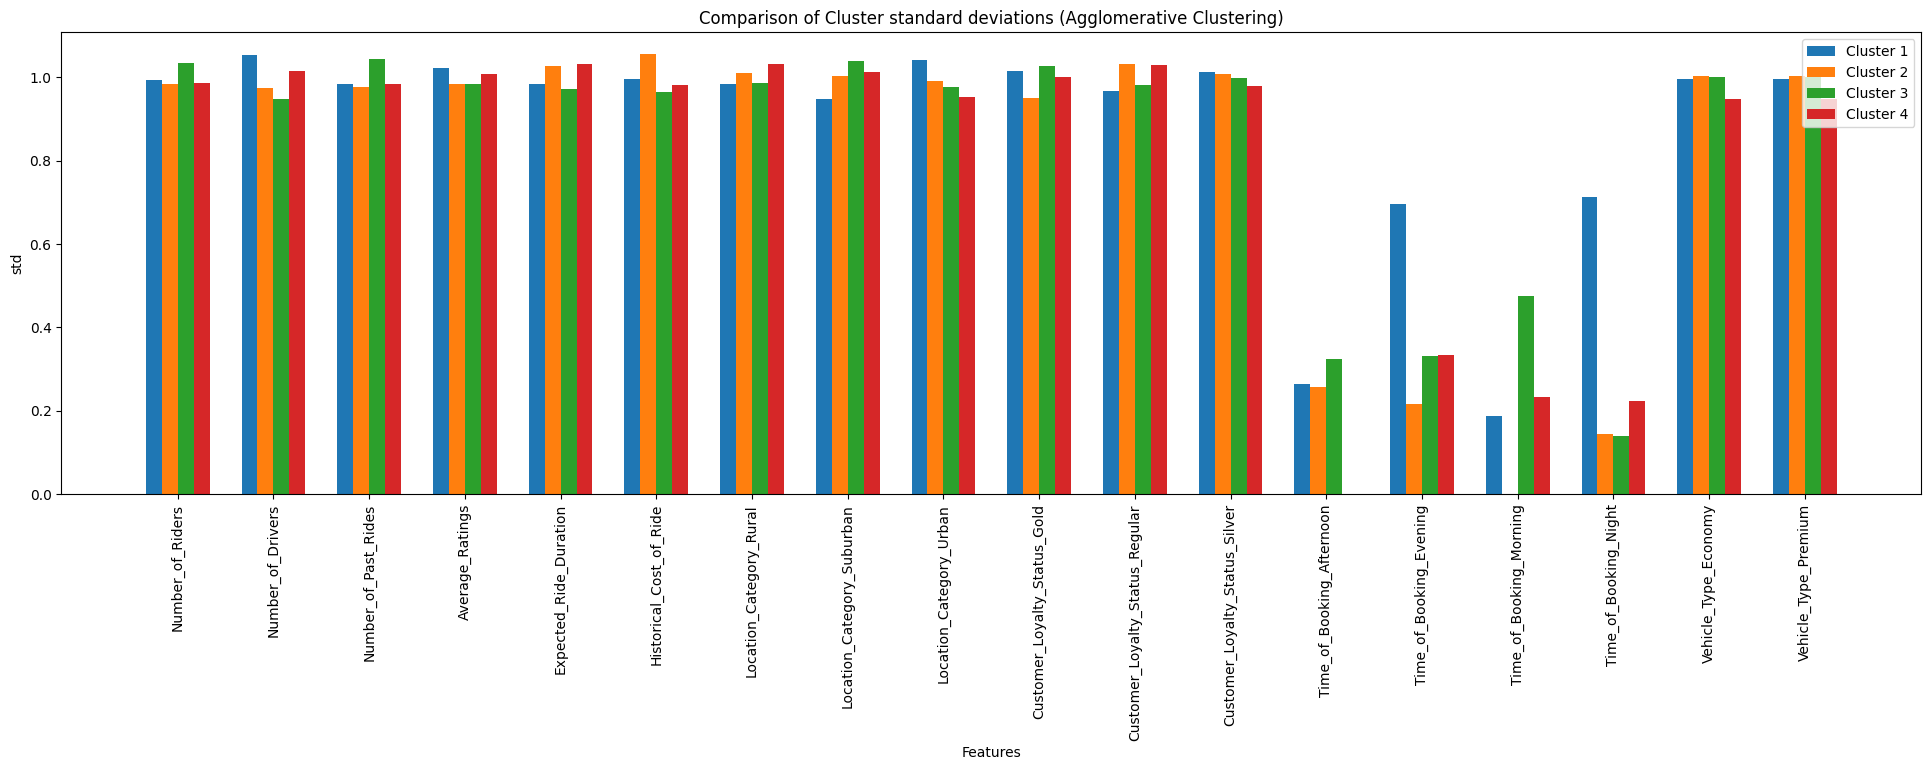

In [26]:
# 4. Calculate the average values for each cluster
cluster_std = X_scaled_agg.groupby('Cluster').std()

# 5. Plot the "centroids" (average values for each cluster)
fig, ax = plt.subplots(figsize=(24, 6))
index = np.arange(len(cluster_std.columns)) * 3  # Spacing on x-axis
bar_width = 0.5

# Add bars for each cluster
for i, row in enumerate(cluster_std.values):
    ax.bar(index + (i * bar_width), row, bar_width, label=f'Cluster {i + 1}')

# Configure the plot
ax.set_xlabel('Features')
ax.set_ylabel('std')
ax.set_title('Comparison of Cluster standard deviations (Agglomerative Clustering)')
ax.set_xticks(index + bar_width * (len(cluster_std) - 1) / 2)
ax.set_xticklabels(cluster_std.columns, rotation=90)
ax.legend()

plt.show()

- La variable de horario es determinante en la definición de los clústeres realizada por el método de aglomeración, ya que cada uno se destaca por un momento específico de reserva, mientras que presenta valores bajos o negativos en los demás. Esto evidencia que las preferencias horarias son el principal criterio de segmentación:
1. Clúster 1: Predomina en reservas nocturnas.
2. Clúster 2: Predomina en reservas durante la tarde.
3. Clúster 3: Predomina en reservas matutinas.
4. Clúster 4: Predomina en reservas al anochecer.
- En relación con el tipo de vehículo, los usuarios del Clúster 4, quienes prefieren reservar al anochecer, muestran una marcada preferencia por vehículos premium.
- Se observa que los usuarios del Clúster 1, que reservan durante la noche, suelen inclinarse por vehículos económicos y, con mayor frecuencia, provienen de zonas urbanas. Además, los usuarios del Clúster 2, que realizan reservas en la tarde, tienden a tener un historial más limitado de viajes acumulados.
- El Clúster 4 se destaca como el más cohesivo y mejor definido, con la menor dispersión interna (baja distancia intraclúster) y el mejor silhouette score.
- El Clúster 1 muestra debilidades, con la mayor dispersión interna y un silhouette score relativamente bajo, lo que sugiere que puede estar agrupando puntos heterogéneos.
- El Clúster 2 tiene la mayor distancia interclúster promedio (3.045), lo que indica que está mejor separado del resto en comparación con otros clústeres.


### Extraer conclusiones del Hierarchical clustering.


- Determinación del número de clústeres: El dendrograma sugiere que el número óptimo de clústeres es 4, ya que este valor maximiza la distancia entre fusiones consecutivas en la jerarquía, lo que respalda la segmentación realizada.
- Importancia de la variable de horario: La variable de horario es clave para la segmentación, ya que cada clúster se define principalmente por un momento específico de reserva:
1. Clúster 1: Reservas nocturnas, con preferencia por vehículos económicos y una mayoría de usuarios urbanos.
2. Clúster 2: Reservas durante la tarde, con un historial más limitado de viajes acumulados.
3. Clúster 3: Reservas matutinas.
4. Clúster 4: Reservas al anochecer, con una marcada preferencia por vehículos premium.
- Calidad de los clústeres: El Clúster 4 es el más cohesivo y mejor definido, con la menor dispersión interna y el mejor silhouette score. El Clúster 1 muestra la mayor dispersión interna y un silhouette score más bajo, lo que sugiere problemas de cohesión.
- Tamaño de los clústeres: El Clúster 1 es el más grande (30.7% de los registros), mientras que el Clúster 4 es el más pequeño (19.9%).












# Paso 3. Presentación del informe de actividades


Link presentación power point: https://1drv.ms/p/s!Ah8Qmdog4Q9AgYMw4z9YBoN6lKs43Q?e=GJJbFI

Link video: https://youtu.be/HIinXDS0m3w

# CONCLUSIONES GENERALES

- Aplicando el algoritmo PCA, es posible reducir el número de variables a 10 para
explicar más del 80% de la varianza, mientras que para conservar el 100% sería necesario utilizar 14 componentes principales.
- Las variables más influyentes en los primeros 10 componentes principales están relacionadas con la hora de reserva, el nivel de lealtad del cliente y la ubicación, mientras que las de menor peso son el promedio de calificaciones y el número de viajes pasados.
- En el k-means, los cuatro clústeres identifican segmentos de clientes según su comportamiento y preferencias: los usuarios más leales y de alta gama predominan en el Clúster 2, mientras que los usuarios ocasionales de lujo conforman el Clúster 1, el más pequeño.
- Para el k-means, el Clúster 4 es el más cohesivo y robusto, con el Silhouette Score más alto, indicando clientes suburbanos altamente coherentes que buscan vehículos económicos.
- En el modelo jerárquico, el dendrograma respalda la segmentación en 4 clústeres, ya que maximiza la distancia entre fusiones consecutivas, mostrando que este número es óptimo para el agrupamiento.
- Para el modelo jerárquico, la variable de horario es clave en la segmentación, con clústeres definidos por momentos específicos de reserva, como el Clúster 1 enfocado en reservas nocturnas y el Clúster 4 en reservas al anochecer, con preferencia por vehículos premium.

# Bibliografía

*   McKinney, W. (2022). Python for data analysis. " O'Reilly Media, Inc.".[Link](http://www.ir.juit.ac.in:8080/jspui/bitstream/123456789/6083/1/Python%20for%20Data%20Analysis_%20Data%20Wrangling%20with%20Pandas%2C%20NumPy%2C%20and%20IPython.pdf)
* Pratap Dangeti. (2017). Statistics for Machine Learning: Build Supervised, Unsupervised, and Reinforcement Learning Models Using Both Python and R (pp.15-28). Packt Publishing. [Link](https://bibliotecavirtual.unad.edu.co/login?url=https://search.ebscohost.com/login.aspx?direct=true&db=e000xww&AN=1560931&lang=es&site=ehost-live&ebv=EB&ppid=pp_83)
* Pratap Dangeti. (2017). Statistics for Machine Learning: Build Supervised, Unsupervised, and Reinforcement Learning Models Using Both Python and R (pp.177-203). Packt Publishing. [Link](https://bibliotecavirtual.unad.edu.co/login?url=https://search.ebscohost.com/login.aspx?direct=true&db=e000xww&AN=1560931&lang=es&site=ehost-live&ebv=EB&ppid=pp_320)
* Pratap Dangeti. (2017). Statistics for Machine Learning: Build Supervised, Unsupervised, and Reinforcement Learning Models Using Both Python and R (pp.177-203). Packt Publishing. [Link](https://bibliotecavirtual.unad.edu.co/login?url=https://search.ebscohost.com/login.aspx?direct=true&db=e000xww&AN=1560931&lang=es&site=ehost-live&ebv=EB&ppid=pp_305)
* Pratap Dangeti. (2017). Statistics for Machine Learning: Build Supervised, Unsupervised, and Reinforcement Learning Models Using Both Python and R (pp.177-203). Packt Publishing. [Link](https://bibliotecavirtual.unad.edu.co/login?url=https://search.ebscohost.com/login.aspx?direct=true&db=e000xww&AN=1560931&lang=es&site=ehost-live&ebv=EB&ppid=pp_305)
